# Example sparql queries for Netpune database

Structured Query Language (SPARQL) is a powerful query language used for querying, updating, and interacting with RDF (Resource Description Framework) data. RDF is a standard model for representing data on the web, and it's particularly well-suited for expressing relationships between resources. SPARQL allows you to retrieve and manipulate RDF data, making it an essential tool for working with semantic web data and graph databases.

The purpose of this notebook is to provide some simple templates for exploratory querying of the database, they are by no means exhaustive. 

## Configuration of the notebook

Before beginning it is important to check that this notebook can access the neptune database that holds the data. The cell below contains two diagnostic commands that if executed, should help determine this. If you cannot access the neptune database it is probably because the notebook is unable to access the VPC that the Neptune database is hosted in, or the IAM permissions for the notebook are not configured. 

#### Debug commands

In [1]:
%status

{'status': 'healthy',
 'startTime': 'Thu Oct 12 09:38:40 UTC 2023',
 'dbEngineVersion': '1.2.1.0.R7',
 'role': 'writer',
 'dfeQueryEngine': 'viaQueryHint',
 'gremlin': {'version': 'tinkerpop-3.6.2'},
 'sparql': {'version': 'sparql-1.1'},
 'opencypher': {'version': 'Neptune-9.0.20190305-1.0'},
 'labMode': {'ObjectIndex': 'disabled',
  'ReadWriteConflictDetection': 'enabled'},
 'features': {'SlowQueryLogs': 'disabled',
  'ResultCache': {'status': 'disabled'},
  'IAMAuthentication': 'enabled',
  'Streams': 'disabled',
  'AuditLog': 'disabled'},
 'settings': {'clusterQueryTimeoutInMs': '120000',
  'SlowQueryLogsThreshold': '5000'},
 'serverlessConfiguration': {'minCapacity': '2.5', 'maxCapacity': '12.0'}}

In [2]:
%graph_notebook_config 

{
  "host": "dev-neptune-cluster-a.cluster-chp1fpphk1ab.eu-west-2.neptune.amazonaws.com",
  "port": 8182,
  "proxy_host": "",
  "proxy_port": 8182,
  "auth_mode": "IAM",
  "load_from_s3_arn": "",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "eu-west-2",
  "sparql": {
    "path": ""
  },
  "gremlin": {
    "traversal_source": "g",
    "username": "",
    "password": "",
    "message_serializer": "graphsonv3"
  },
  "neo4j": {
    "username": "neo4j",
    "password": "password",
    "auth": true,
    "database": null
  }
}


### Basic Sparql queries for probing catalogue data

#### List all subjects & predicates

The following query lists all unique subjects and predicates. If the "LIMIT" is removed - this list may be comprehensive, but difficult to navigate.

In [3]:
%%sparql

SELECT (COUNT(DISTINCT ?subject) as ?subjectCount) (COUNT(DISTINCT ?predicate) as ?predicateCount)
WHERE {
  ?subject ?predicate ?object
}


In [4]:
%%sparql

SELECT DISTINCT ?subject ?predicate
WHERE {
  ?subject ?predicate ?object
} LIMIT 100


#### Simple count

In [5]:
%%sparql

SELECT (COUNT(*) AS ?count)
WHERE {
  ?subject ?predicate ?object
}


#### Retrieve specific types of a resource 

In [6]:
%%sparql

SELECT ?subject ?predicate
WHERE {
  ?subject ?predicate "agent.48K" .
}


#### Retrieve queries that share a resource between them

In [7]:
%%sparql 

SELECT *
WHERE {
  ?start ?predicate1 ?intermediate .
  ?intermediate ?predicate2 ?end .
}
LIMIT 100


#### Retrieve the subject nodes with the most connections

In [8]:
%%sparql

SELECT ?subject (COUNT(*) as ?count)
WHERE {
  ?subject ?predicate ?object .
}
GROUP BY ?subject
ORDER BY DESC(?count)
LIMIT 1

#### Visualising the subject node and it's connections

In [9]:
%%sparql

SELECT ?subject ?predicate ?object
WHERE {
  <http://cat.nationalarchives.gov.uk/COAL.2022.N2CL.P.1> ?predicate ?object .
  BIND (<http://cat.nationalarchives.gov.uk/COAL.2022.N2CL.P.1> AS ?subject)
}



#### Finding the object node with the most connections 

In [10]:
%%sparql


SELECT ?object (COUNT(?predicate) AS ?connections)
WHERE {
  ?subject ?predicate ?object .
}
GROUP BY ?object
ORDER BY DESC(?connections)
LIMIT 1



#### Visualising the node with the most connections 

In [11]:
%%sparql

SELECT ?subject ?predicate ?object
WHERE {
  ?subject ?predicate ?object .
  FILTER (?object = <http://cat.nationalarchives.gov.uk/agent.S7>)
} LIMIT 1000


#### Finding objects with different subjects 

In [12]:
%%sparql

SELECT ?s1 ?p1 ?o
WHERE {
  ?s1 ?p1 ?o .
  ?s2 ?p2 ?o .
  FILTER (?s1 != ?s2)
} LIMIT 1000


#### Storing query results for further analysis 

In [13]:
%%sparql --store-to sparql_results

SELECT DISTINCT ?subject ?predicate
WHERE {
  ?subject ?predicate ?object
} 


#### Using stored values for further analysis 

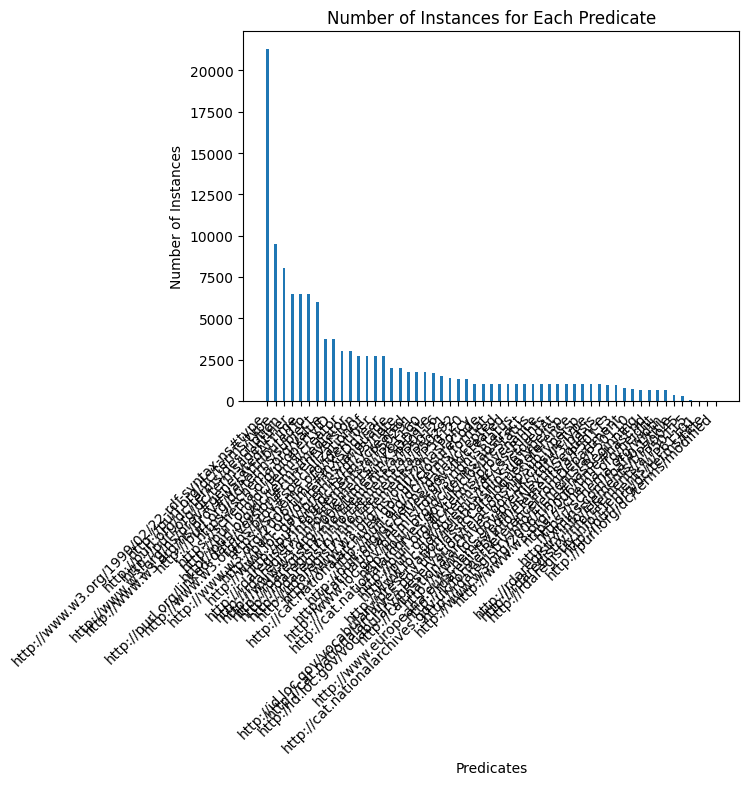

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

bindings = sparql_results['results']['bindings']

predicates = [binding['predicate']['value'] for binding in bindings]

df = pd.DataFrame({'predicate': predicates})

predicate_counts = df['predicate'].value_counts()

%matplotlib inline

# adjust these to format graph
bar_width = 0.5  # Width of each bar
spacing = 1   # Space between bars
positions = range(len(predicate_counts))
bar_positions = [pos * (bar_width + spacing) for pos in positions]

plt.bar(bar_positions, predicate_counts.values, width=bar_width)

# Set the positions and labels for the ticks on the x-axis
plt.xticks(bar_positions, predicate_counts.index, rotation=45, ha="right")

plt.xlabel('Predicates')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Predicate')
plt.show()

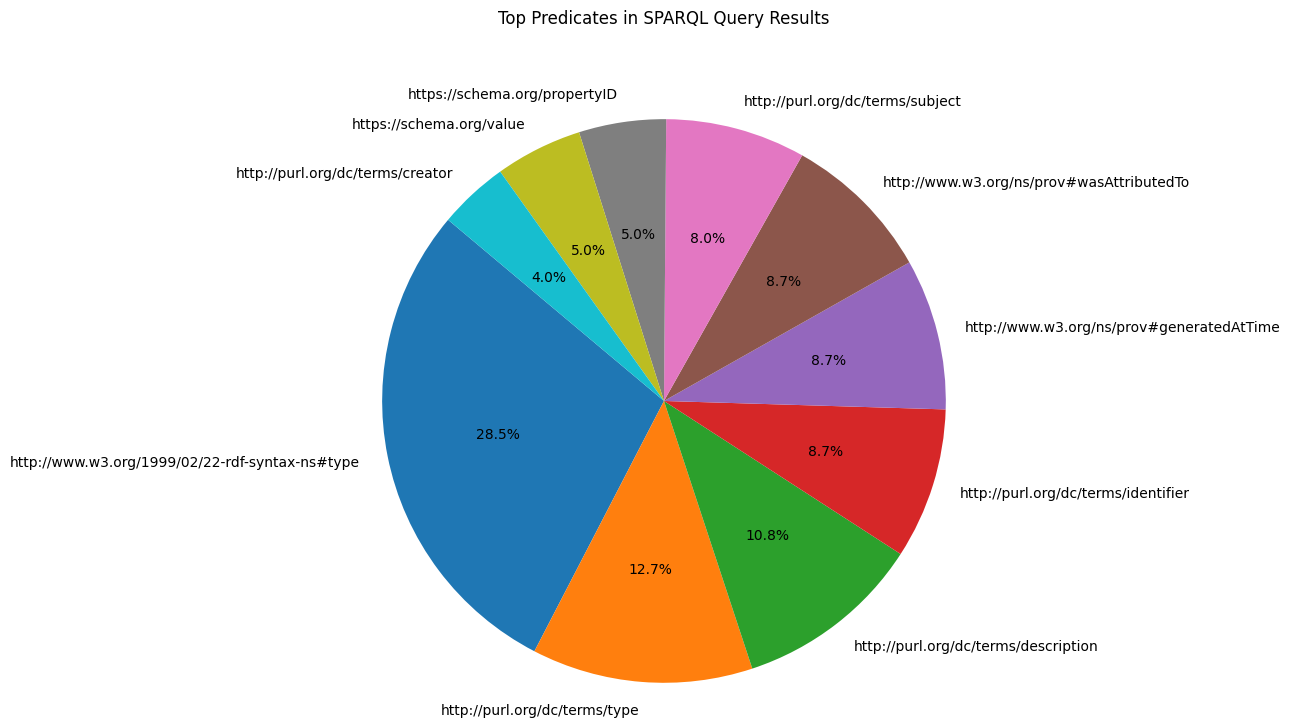

In [15]:
import matplotlib.pyplot as plt

labels = [result['subject']['value'] for result in sparql_results['results']['bindings']]
predicates = [result['predicate']['value'] for result in sparql_results['results']['bindings']]

predicate_counts = {}
for predicate in predicates:
    if predicate in predicate_counts:
        predicate_counts[predicate] += 1
    else:
        predicate_counts[predicate] = 1

sorted_predicates = sorted(predicate_counts.items(), key=lambda x: x[1], reverse=True)

N = 10  # You can adjust this value to display the top N predicates
top_predicates = [predicate[0] for predicate in sorted_predicates[:N]]
top_counts = [predicate[1] for predicate in sorted_predicates[:N]]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_counts, labels=top_predicates, autopct='%1.1f%%', startangle=140)

plt.title('Top Predicates in SPARQL Query Results', y=1.10)# Adjust the y value to control title position

plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
plt.show()


#### What's wrong with an old fashioned table

In [16]:
import pandas as pd

# Extract 'predicate' values
predicate_values = [result['predicate']['value'] for result in sparql_results['results']['bindings']]
df = pd.DataFrame({'Predicate': predicate_values})
predicate_counts = df['Predicate'].value_counts().reset_index()
predicate_counts.columns = ['Predicate', 'Count']
predicate_counts['Percentage'] = (predicate_counts['Count'] / predicate_counts['Count'].sum() * 100).round(2)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
# Display the DataFrame
print(predicate_counts)

                                            Predicate  Count  Percentage
0     http://www.w3.org/1999/02/22-rdf-syntax-ns#type  21299       16.64
1                       http://purl.org/dc/terms/type   9471        7.40
2                http://purl.org/dc/terms/description   8060        6.30
3                 http://purl.org/dc/terms/identifier   6471        5.05
4           http://www.w3.org/ns/prov#generatedAtTime   6470        5.05
5           http://www.w3.org/ns/prov#wasAttributedTo   6470        5.05
6                    http://purl.org/dc/terms/subject   6000        4.69
7                            https://schema.org/value   3735        2.92
8                       https://schema.org/propertyID   3735        2.92
9                    http://purl.org/dc/terms/creator   3001        2.34
10                  http://purl.org/dc/terms/mediator   3000        2.34
11  http://purl.org/linked-data/version#currentVer...   2735        2.14
12         http://www.w3.org/ns/prov#specialization

#### Some interesting queries to show aspects of the "Coal 80" subset 

In [17]:
%%sparql

PREFIX dct: <http://purl.org/dc/terms/>
PREFIX cat: <http://cat.nationalarchives.gov.uk/>
PREFIX ver: <http://purl.org/linked-data/version#>

describe ?personConcept ?personDescription ?name
where { ?personConcept dct:type cat:person-concept ;
       ver:currentVersion ?personDescription . } LIMIT 500

#### Searching out the Titles

A count of all triples in datastore that hold a title

In [18]:
%%sparql --store-to total_all 

SELECT (COUNT(*) as ?count)
WHERE {
  ?subject <http://xmlns.com/foaf/0.1/title> ?title .
  ?subject ?predicate ?object .
  FILTER (strstarts(str(?predicate), "http://rdaregistry.info/Elements/a/"))
}



A count of all the women who hold titles

In [19]:
%%sparql --store-to total_women

SELECT (COUNT(*) as ?count)
WHERE {
  ?subject <http://xmlns.com/foaf/0.1/title> ?title .
  ?subject ?predicate ?object .
  FILTER (strstarts(str(?predicate), "http://rdaregistry.info/Elements/a/"))
  FILTER (!(EXISTS { ?subject <http://rdaregistry.info/Elements/a/P50116> "Male" }))
}


A count of all the men who hold titles

In [20]:
%%sparql --store-to total_men

SELECT (COUNT(*) as ?count)
WHERE {
  ?subject <http://xmlns.com/foaf/0.1/title> ?title .
  ?subject <http://rdaregistry.info/Elements/a/P50116> "Male" .
  ?subject ?predicate ?object .
  FILTER (strstarts(str(?predicate), "http://rdaregistry.info/Elements/a/"))
}


A count of all the women who hold titles

In [21]:
%%sparql

SELECT ?subject ?predicate ?object
WHERE {
  ?subject <http://xmlns.com/foaf/0.1/title> ?title .
  ?subject ?predicate ?object .
  FILTER (strstarts(str(?predicate), "http://rdaregistry.info/Elements/a/"))
  FILTER (!(EXISTS { ?subject <http://rdaregistry.info/Elements/a/P50116> "Male" }))
} 



In [22]:
%%sparql 

SELECT ?subject ?predicate ?object
WHERE {
  ?subject <http://xmlns.com/foaf/0.1/title> ?title .
  ?subject <http://rdaregistry.info/Elements/a/P50116> "Male" .
  ?subject ?predicate ?object .
  FILTER (strstarts(str(?predicate), "http://rdaregistry.info/Elements/a/"))
}


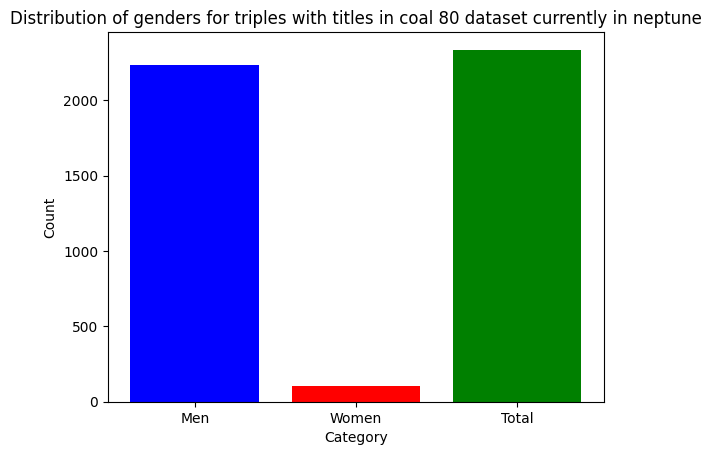

In [23]:
# Define the data
categories = ['Men', 'Women', 'Total']
counts = [int(total_men['results']['bindings'][0]['count']['value']),
          int(total_women['results']['bindings'][0]['count']['value']),
          int(total_all['results']['bindings'][0]['count']['value'])]

# Create a bar chart
plt.bar(categories, counts, color=['blue', 'red', 'green'])
# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of genders for triples with titles in coal 80 dataset currently in neptune')
plt.show()


In [24]:
%%sparql --store-to gender_time_series

SELECT ?subject ?title ?gender ?created
WHERE {
  ?subject <http://xmlns.com/foaf/0.1/title> ?title .
  ?subject <http://rdaregistry.info/Elements/a/P50116> ?gender .
  ?subject <http://purl.org/dc/terms/created> ?created .  
}


#### Visualising this data as a time series

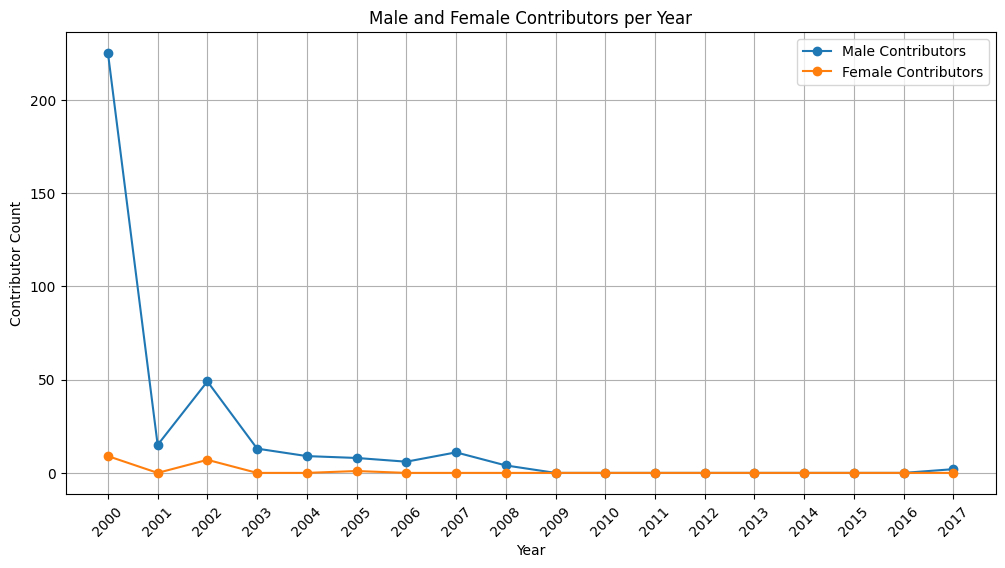

In [25]:
import matplotlib.pyplot as plt
from collections import defaultdict


# Create dictionaries to store the counts for male and female contributors per year
male_contributors = defaultdict(int)
female_contributors = defaultdict(int)


# Extract and process the data
bindings = gender_time_series['results']['bindings']
for entry in bindings:
    year = entry['created']['value'][:4]  # Extract the year from the 'created' value
    gender = entry['gender']['value']
    if gender == 'Male':
        male_contributors[year] += 1
    elif gender == 'Female':
        female_contributors[year] += 1

min_year = min(int(year) for year in male_contributors.keys() | female_contributors.keys())
max_year = max(int(year) for year in male_contributors.keys() | female_contributors.keys())

all_years = [str(year) for year in range(min_year, max_year + 1)]

male_counts = [male_contributors.get(year, 0) for year in all_years]
female_counts = [female_contributors.get(year, 0) for year in all_years]

plt.figure(figsize=(12, 6))
plt.plot(all_years, male_counts, label='Male Contributors', marker='o')
plt.plot(all_years, female_counts, label='Female Contributors', marker='o')
plt.xlabel('Year')
plt.ylabel('Contributor Count')
plt.title('Male and Female Contributors per Year')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


#### The big finale

In [13]:
%%sparql 

SELECT *
WHERE {
  ?subject ?predicate ?object
} LIMIT 10000